In [ ]:
data = pd.read_csv('/content/ticket_data.csv')

data.head()

print(data.isnull().sum())

print(data.describe())


date               0
ticket_type        0
category           0
priority           0
team               0
resolution_time    0
ticket_count       0
day_of_week        0
month              0
dtype: int64
       resolution_time  ticket_count  day_of_week        month
count      1000.000000   1000.000000  1000.000000  1000.000000
mean         51.074000     10.330000     3.023000     6.531000
std          28.038379      5.322352     2.013088     3.408322
min           1.000000      1.000000     0.000000     1.000000
25%          27.000000      6.000000     1.000000     4.000000
50%          53.000000     11.000000     3.000000     7.000000
75%          75.000000     15.000000     5.000000     9.000000
max          99.000000     19.000000     6.000000    12.000000


In [ ]:
# Convert 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

data['day_of_week'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month

print(data.isnull().sum())

# Drop rows with missing values in ticket_count (if any)
data = data.dropna(subset=['ticket_count'])

data.head()


date               0
ticket_type        0
category           0
priority           0
team               0
resolution_time    0
ticket_count       0
day_of_week        0
month              0
dtype: int64


,date,ticket_type,category,priority,team,resolution_time,ticket_count,day_of_week,month
0,2023-01-01,Incident,Software,High,Team D,88,2,6,1
1,2023-01-01,Inquiry,Network,High,Team D,8,13,6,1
2,2023-01-01,Inquiry,Software,Critical,Team B,43,12,6,1
3,2023-01-01,Incident,Network,Critical,Team C,55,19,6,1
4,2023-01-01,Feature Request,Software,Medium,Team B,54,14,6,1


In [ ]:
# Aggregate ticket counts by date (in case there are multiple entries per day)
daily_data = data.groupby('date').agg({
    'ticket_count': 'sum',
    'day_of_week': 'mean',
    'month': 'mean'
}).reset_index()

daily_data.head()


,date,ticket_count,day_of_week,month
0,2023-01-01,64,6.0,1.0
1,2023-01-02,45,0.0,1.0
2,2023-01-03,17,1.0,1.0
3,2023-01-04,36,2.0,1.0
4,2023-01-05,61,3.0,1.0


In [ ]:
train_data = daily_data[:int(0.8 * len(daily_data))]
test_data = daily_data[int(0.8 * len(daily_data)):]

print(f"Training Data Shape: {train_data.shape}")
print(f"Testing Data Shape: {test_data.shape}")


Training Data Shape: (268, 4)
Testing Data Shape: (68, 4)


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

holt_winters_model = ExponentialSmoothing(
    train_data['ticket_count'],  # The target variable
    trend='add',  # Adding a trend component
    seasonal='add',  # Adding a seasonal component
    seasonal_periods=7  # Weekly seasonality (7 days)
)

holt_winters_model_fitted = holt_winters_model.fit()

forecast = holt_winters_model_fitted.forecast(len(test_data))

print(forecast[:5])


268    30.422284
269    35.708750
270    35.887899
271    32.424871
272    32.554739
dtype: float64


Mean Absolute Error (MAE): 15.801973263110039


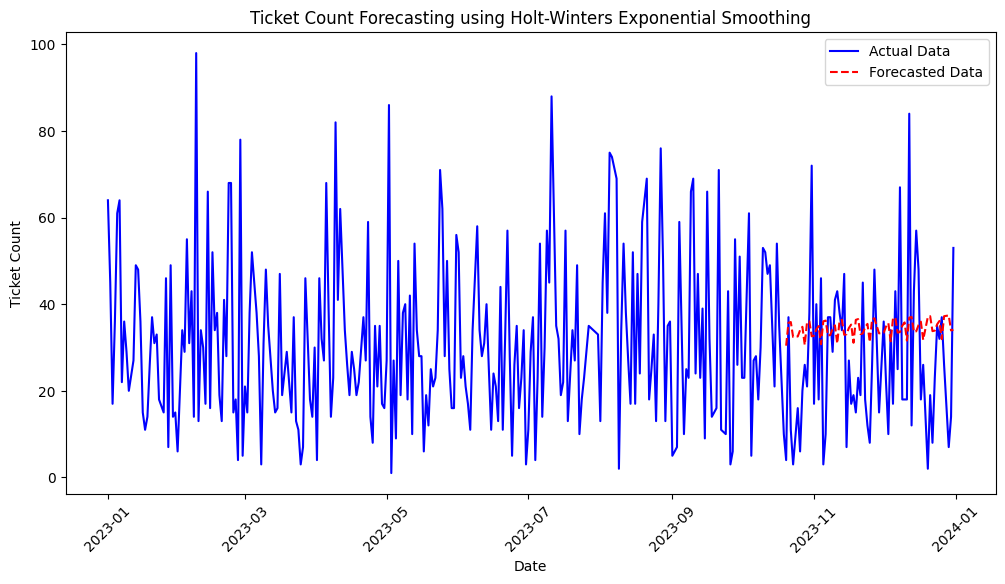

In [ ]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

mae = mean_absolute_error(test_data['ticket_count'], forecast)
print(f'Mean Absolute Error (MAE): {mae}')

plt.figure(figsize=(12, 6))
plt.plot(daily_data['date'], daily_data['ticket_count'], label='Actual Data', color='blue')
plt.plot(test_data['date'], forecast, label='Forecasted Data', color='red', linestyle='dashed')
plt.title("Ticket Count Forecasting using Holt-Winters Exponential Smoothing")
plt.xlabel('Date')
plt.ylabel('Ticket Count')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [ ]:
forecast_df = pd.DataFrame({
    'date': test_data['date'],
    'actual_ticket_count': test_data['ticket_count'],
    'forecasted_ticket_count': forecast
})
forecast_df.to_csv('/content/forecast_results.csv', index=False)

import pickle
with open('/content/holt_winters_model.pkl', 'wb') as model_file:
    pickle.dump(holt_winters_model_fitted, model_file)

print("Files saved: forecast_results.csv, holt_winters_model.pkl")


Files saved: forecast_results.csv, holt_winters_model.pkl
